# Lección 4: Protocolo de teleportación

Los estados entrelazados, como lo hemos visto en las sesiones anteriores, permiten realizar cosas bastante interesantes. La propiedad de entrelazamiento entre un par de partículas dio pie para la proposición de diferentes protocolos cuánticos cuyas posibles aplicaciones se exploran aún en la actualidad.

En esta lección analizaremos en detalle el protocolo de teleportación. Este protocolo es posible gracias a las propiedades del entrelazamiento entre dos partículas. 

Las fuentes de este tipo de partículas las llamaremos fuentes EPR por los autores del artículo *Can Quantum-Mechanical Description of Physical Reality Be Considered Complete?* publicado por Albert Einstein, Boris Podolsky, y Nathan Rosen en 1935 en donde se muestra como el formalismos de la mecánica cuántica permite que un par de partículas compartan esta propiedad de entrelazamiento.

**SUPER IMPORTANTE:** En este ejemplo intentaremos presentar al lector cómo simular el protocolo cuántico de teleportación en un computador cuántico. Esta sesiónes está disponible en nuestro servidor de MyBinder.
​
<p align="center">
  <a href="https://mybinder.org/v2/gh/QC-FEM/QC-CrashCourse/HEAD">
    <img src="https://mybinder.org/badge_logo.svg">
  </a>
</p>

Como de costumbre realizamos las importaciones necesarias para neustro circuito.

In [1]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram,state_visualization
from qiskit.quantum_info.operators import Operator
import matplotlib.pyplot as plt
import numpy as np

El protocolo de teleportación sigue el siquiente esquema y se puede ver resumido en 3 pasos.
<img src="Lec_4_Teleportacion_files/QTP.png" alt="drawing" width="500"/>

- Paso 1: Una fuente EPR, la cual es una fuente de partículas entrelazadas, entrega un par de partículas entrelazadas a Alice y Bob. A la partícula de Alice la llamamos $A$ y a la partícula de Bob la llamamos $B$. Estas partículas deben estar entrelazadas en un estado de Bell, en este ejemplo partícular elegimos el estado de la forma $|\Phi^{+}\rangle_{AB} = \frac{1}{\sqrt{2}}|00\rangle + \frac{1}{\sqrt{2}} |11\rangle$.
- Paso 2: Entonces, en este protocolo Alice desea a teleportar a Bob el estado de una partícula $A'$ que se encuentra en un estado arbitrario $|\psi\rangle_{A'} = \alpha|0\rangle + \beta|1\rangle$. Una vez Alice recibe su partícula $A$ esta prepara un estado entrelazado conjunto entre las tres parttículas que tiene la forma $|\Psi\rangle_{A'AB} =|\psi\rangle_{A'} \otimes |\Phi^{+}\rangle_{AB}$. Lo anterior se debe a que el estado total de un sistema cuántico compuesto por más de una partícula se escribe en términos del producto de Kronecker entre los estados de las partículas individuales. Como Alice ya tiene el estado total, ella realiza una medición sobre las partículas $A$ y $A'$ en la base de Bell para saber en cual estado de esta base se encuentra el par de partículas.
- Paso 3: Alice tiene que comunicar a Bob el resultado de su medición, esto lo tiene que hacer a través de un *canal clásico*, es decir, a traves de una llamada, un correo, un mensaje de texto o algo similar. Una vez bob recibe esta información, realiza las operaciones unitarias necesarias sobre su partícula para que esta quede en el estado inicial de la partícula $A'$, es decir, la partícula de Bob al final terminará en el estado $|\psi\rangle_B = \alpha|0\rangle + \beta |1\rangle$.

Para realizar el protocolo definimos algunas funciones auxiliares. La función `initialize_qubit` inicializa el qubit que vamos a teleportar desde Alice hasta Bob. En este caso, este estará en el estado


$$|\psi\rangle_{A'} = \sqrt{\frac{1}{4}}|0\rangle + \sqrt{\frac{3}{4}}|1\rangle$$


In [2]:
def initialize_qubit(circuit, qubit_index):
    
    ## Inicialización del qubit a teleportar
    a= [np.sqrt(0.25),np.sqrt(0.75)]
    circuit.initialize(a,qubit_index)
        
   
    return circuit

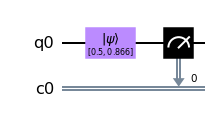

In [3]:
## Inicializamos todo el circuito 
qubit_Teleported = QuantumRegister(1)
cr_qt = ClassicalRegister(1)

qc = QuantumCircuit(qubit_Teleported,cr_qt)
initialize_qubit(qc, 0)

qc.measure(qubit_Teleported,cr_qt)

qc.draw(output='mpl')


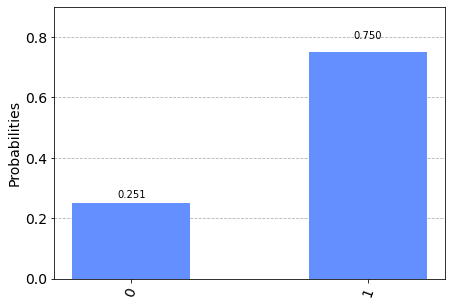

In [4]:
backend = Aer.get_backend('qasm_simulator')
counts = execute(qc,backend,shots=10000).result().get_counts()
plot_histogram(counts)

Ahora realizamos preparamos el par de partículas entrelazadas que comparten Alice y Bob, en este caso particular estas van a estar en el estado 

$$|\Phi^+\rangle_{AB} = \frac{1}{\sqrt{2}}|00\rangle + \frac{1}{\sqrt{2}} |11\rangle.$$

Para mostrar en qué estado está esta partícula iniciamos un registro con esta función y visualizaremos su histograma

In [5]:
def entangle_qubits(circuit, q_Alice, q_Bob):
    
    ## Entrelazamos el primer par de qubits en un estado de Bell
    circuit.h(q_Alice)                 ## Hadamard sobre el qubit de Alice
    circuit.cx(q_Alice,q_Bob)          ## CNOT para entrelazar los qubits de Alice y Bob
     
    
    return circuit

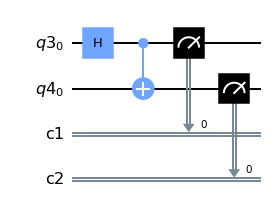

In [6]:
## Inicializamos todo el circuito 
qubit_Alice = QuantumRegister(1)
qubit_Bob = QuantumRegister(1)
cr_Alice = ClassicalRegister(1)
cr_Bob = ClassicalRegister(1)

qc_EPR = QuantumCircuit(qubit_Alice,qubit_Bob,cr_Alice,cr_Bob)

## Realizamos el entrelazamiento
entangle_qubits(qc_EPR,0,1)

qc_EPR.measure(qubit_Alice,cr_Alice)
qc_EPR.measure(qubit_Bob,cr_Bob)

qc_EPR.draw(output='mpl')

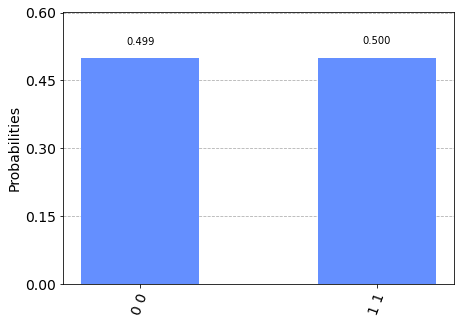

In [7]:
backend = Aer.get_backend('qasm_simulator')
counts = execute(qc_EPR,backend,shots=10000).result().get_counts()
plot_histogram(counts)

Con esto en mente, ahora definimos una función que realiza la medición del estado de Bell en el que están el qubit de alice y el estado que ella quiere teleportar. Para esto primero se debe pasar estos dos qubits a la base de Bell, esto se hace a través de la operación de la función anterior, de este modo las mediciones nos indican en qué estado de la base de Bell se encuentran siguiendo la siguiente correspondencia

$$ |00 \rangle\longrightarrow |\Phi^+\rangle_{A'A} = \frac{1}{\sqrt{2}}\left(|00 \rangle + |11\rangle\right)$$
$$ |01 \rangle\longrightarrow |\Psi^+\rangle_{A'A} = \frac{1}{\sqrt{2}}\left(|01 \rangle + |10\rangle\right)$$
$$ |10 \rangle\longrightarrow |\Phi^-\rangle_{A'A} = \frac{1}{\sqrt{2}}\left(|00 \rangle - |11 \rangle\right)$$
$$ |11 \rangle\longrightarrow |\Psi^-\rangle_{A'A} = \frac{1}{\sqrt{2}}\left(|01 \rangle - |10\rangle\right)$$


In [8]:
def bell_measurement(circuit, q1_Alice, q2_Alice, c1_Alice, c2_Alice):
    
    ## Acá Alice realiza la medición del estado de Bell para esto lleva los estados a dicha base y realiza la medición
    circuit.cx(q1_Alice, q2_Alice)
    circuit.h(q1_Alice)
    
    ## Los resultados que obtenga Alice indicarán en qué estado está la partícula de Bob |s,a>
    circuit.barrier()
    circuit.measure(q1_Alice, c1_Alice)
    circuit.measure(q2_Alice, c2_Alice)

    return circuit

De acuerdo con el resultado de la medición anterior, la partícula de bob va a estar en un estado definido teniendo en cuenta que 
$$|\psi\rangle_{A' A B} =\frac{1}{2}{\color{red}{|\Phi^{+}\rangle_{A' A}}} \left(\alpha|0\rangle_{B}+\beta|1\rangle_{B}\right)$$

$$\hspace{3.4em}+\frac{1}{2}{\color{red}{|\Phi^{-}\rangle_{A' A}}}\left(\alpha|0\rangle_{B}-\beta|1\rangle_{B}\right)$$

$$\hspace{3.4em}+\frac{1}{2}{\color{red}{|\Psi^{+}\rangle_{A'A}}}\left(\alpha|1\rangle_{B}+\beta|0\rangle_{B}\right)
$$

$$\hspace{3.4em}+\frac{1}{2}{\color{red}{|\Psi^{-}\rangle_{A' A}}}\left(\alpha|1\rangle_{B}-\beta|0\rangle_{B}\right) $$

No es inmediato pero se puede ver que, cuando el qubit $A$, que es el qubit que está entrelazado con el de bob, esta en el estado 1, entonces se debe aplicar una compuerta X sobre el estado de Bob para negr los estados. Por otra parte, cuando el qubit $A'$ está en el estado 1, toca aplicar una compuerta $Z$ que cambie la fase relativa entre los posibles estados de la partícula de Bob. Estas condiciones se pueden escribir de la forma

In [9]:
def controlled_ops_Bob_qubit(circuit, q_Bob, c1_Alice, c2_Alice):
    
    ## Dependiendo de los resultados recibidos en los qubits de alice, Bob realiza la operación necesaria
    circuit.x(q_Bob).c_if(c2_Alice, 1) ## Si c2_A = 1, se aplica x
    circuit.z(q_Bob).c_if(c1_Alice, 1) ## Si c1_A = 1, se aplica z
    
    return circuit

Ahora lo ponemos todo junto y ejecutamos el protocolo, este se puede resumir en el siguiente esquema.




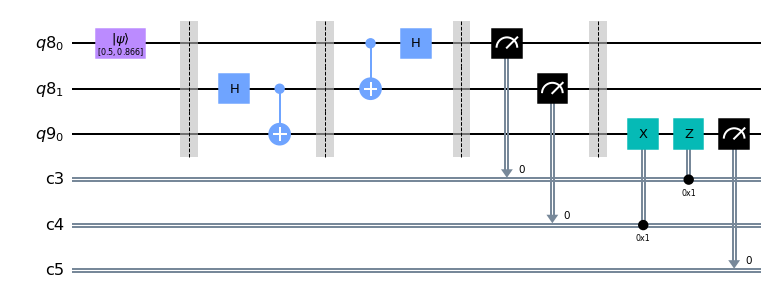

In [10]:
## Inicializamos todo el circuito 
qubits_Alice = QuantumRegister(2)
qubits_Bob = QuantumRegister(1)
cr1_Alice = ClassicalRegister(1)
cr2_Alice = ClassicalRegister(1)
cr_Bob = ClassicalRegister(1)

## Acá ejecutamos el protocolo, primero inicializamos nuestro circuito
qc = QuantumCircuit(qubits_Alice, qubits_Bob, cr1_Alice, cr2_Alice,cr_Bob)
initialize_qubit(qc, 0)
qc.barrier()

## Paso 1: Entregamos a Bob y a alice un par de partículas enrtelazadas
entangle_qubits(qc, 1, 2)
qc.barrier()

## Paso 2: Alice realiza el BSM entre su partícula y la que desea teleportar
bell_measurement(qc, qubits_Alice[0], qubits_Alice[1], cr1_Alice, cr2_Alice)
qc.barrier()

## Paso 3: Bob aplica las compuertas necesarias para que su partícula esté en el estado deseado
controlled_ops_Bob_qubit(qc, qubits_Bob[0], cr1_Alice, cr2_Alice)

## Medimos la partícula de Bob para comprobar que la teleportacion se dio bien
qc.measure(2,cr_Bob)

## El circuito toma la forma
qc.draw(output='mpl')

{'0': 2508, '1': 7492}


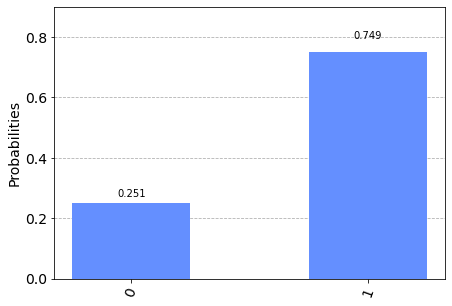

In [11]:
## Simulamos el circuito
backend = Aer.get_backend('qasm_simulator')
counts = execute(qc,backend,shots=10000).result().get_counts()

## Creamos un diccionario para almacenar los resultados del qubit de Bob
Bob_dict = {'0' : 0, '1' : 0}

## Llenamos el diccionario de los resultados del qubit de Bob
for count in counts:
    if (count[0] == '0'):
        Bob_dict['0'] += counts[count]
    elif(count[0] == '1'):
        Bob_dict['1'] += counts[count]

print(Bob_dict)

## Mostramos el histograma para el qubit de Bob
plot_histogram(Bob_dict)

Como se puede ver en el histograma anterior, el qubit de Bob tiene probabilidad de $25\%$ de estar en el estado $|0\rangle$ y probabilidad del $75\%$ de estar en el esatdo $|1\rangle$. Tal y como el estado inicial que queríamos teleportar, por lo cual, el protocolo se ha cumplido correctamente.

Es importante notar que Alice no teleportó la partícula $A'$ como tal, lo que ella hizo fue una medición de su partícula y luego indicar a Bob que operaciones realizar sobre para que el qubit esta quedara exactamente en el estado de superposición que Alice deseaba teleportar, es decir, no se está creando una copia del estado que se deseaba teleportar, más bien se realizó una medición sobre este estado con el objetivo de reproducirlo en otro lugar.

## Referencias

* Einstein, Podolsky & Rosen. **Can Quantum-Mechanical Description of Physical Reality Be Considered Complete?**. Phys. Rev. 47, 777, 1935.
* Nielsen & Chuang. **Quantum Computation and Quantum Information**. Cambridge University Press, 2010.
* Bouwmeester D., Ekert A. & Zeilinger A. **The Physics of Quantum Information**. Springer-Verlag, 2001. 
* Wilde. **Quantum Information Theory**. Cambridge University Press, 2013.

Muchas gracias por leer esta publicación! Abajo se encuentran links a las lecciones siguientes en el Crash Course de QC-FEM.